# 📚 1. Standard Library and Configuration

In [1]:
import sys
sys.path.append("..")

# --- 1. SYSTEM & ENVIRONMENT CONFIGURATION ---
import os
import random
from warnings import filterwarnings

# Matikan log TensorFlow yang tidak perlu (Set sebelum import TF)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Abaikan warnings
filterwarnings("ignore")


# --- Core Library ---
import numpy as np
import pandas as pd
from src.utils import (
    set_seed, get_logger, clean_feature_names,
    safe_assert_sufficient_rows
)

# --- Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt
from src.viz import (
    plot_target, plot_correlation, plot_value_counts, plot_features
)


# --- Scikit Learn ---
# Model Selection & Evaluation
from sklearn.model_selection import (
    KFold,
    cross_validate,
    cross_val_score,
    train_test_split
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from src.evaluate import (
    evaluate_final_model, plot_feature_importance_from_pipeline
)

# Preprocessing & Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler
)
from src.preprocess import (
    build_preprocessor, fit_transform_df
)


# --- Deep Learning Frameworks ---
# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau
)
from src.dnn import (
    build_dnn_model, run_dnn_cv,
    train_final_dnn, explain_dnn_feature_importance
)

# ML Models
import optuna
from optuna import Trial
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from src.tuning import tune_model

# --- Global Constant ---
N_SPLITS = 5
EPOCHS = 300
BATCH_SIZE = 8
DATA_PATH = 'data/insurance.csv'

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    try:
        tf.config.experimental.enable_op_determinism()
    except AttributeError:
        print("Warning: tf.config.experimental.enable_op_determinism() tidak tersedia di versi TF ini.")

SEED = 42
set_seed(SEED)

print('Library and Configuration Ready!')

Library and Configuration Ready!


# 📊 2. Load Data

## Dataset Penelitian: Medical Cost Personal Dataset

Dataset yang digunakan dalam penelitian merupakan **Medical Cost Personal Dataset** yang diperoleh dari laman Kaggle (sumber: [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance/data)). Dataset ini berisi data individu yang diasuransikan, dengan tujuan untuk menganalisis faktor-faktor yang memengaruhi besarnya klaim medis (*medical charges*) yang ditanggung oleh perusahaan asuransi kesehatan.

Secara keseluruhan, dataset ini terdiri atas **1.338 observasi** dan **7 variabel** yang mencakup karakteristik demografis, kondisi kesehatan, serta informasi biaya klaim. Adapun penjelasan tiap variabel adalah sebagai berikut.

---

### Deskripsi Variabel

* **age**: Usia tertanggung utama (*primary beneficiary*) yang diasuransikan. Umur merupakan faktor risiko utama dalam klaim kesehatan karena berkorelasi positif dengan frekuensi dan keparahan klaim.
* **sex**: Jenis kelamin tertanggung, terdiri atas kategori *female* dan *male*. Variabel ini digunakan untuk menilai adanya perbedaan biaya klaim antara laki-laki dan perempuan.
* **bmi**: *Body Mass Index* (BMI), yaitu indeks massa tubuh yang dihitung dari rasio berat badan terhadap tinggi badan (kg/m²). Nilai ideal berada pada kisaran 18,5–24,9. BMI digunakan sebagai indikator risiko kesehatan seperti obesitas yang berpotensi meningkatkan biaya klaim.
* **children**: Jumlah anak atau tanggungan yang tercakup dalam polis asuransi kesehatan. Variabel ini menunjukkan beban keluarga dalam perlindungan asuransi.
* **smoker**: Status kebiasaan merokok tertanggung (*yes* atau *no*). Faktor ini sangat berpengaruh terhadap besarnya premi maupun klaim karena berkaitan langsung dengan risiko penyakit kronis.
* **region**: Wilayah tempat tinggal tertanggung di Amerika Serikat, dengan kategori *northeast*, *southeast*, *southwest*, dan *northwest*. Variabel ini dapat mencerminkan perbedaan biaya layanan kesehatan antar wilayah.
* **charges**: Total biaya medis individual yang ditagihkan kepada perusahaan asuransi (*individual medical costs billed by health insurance*). Variabel ini menjadi variabel target (*dependent variable*) yang akan diprediksi dalam penelitian ini.

---

Dengan karakteristik tersebut, dataset ini dinilai sesuai untuk mendukung analisis faktor-faktor yang memengaruhi besarnya klaim asuransi kesehatan menggunakan pendekatan *machine learning*. Selain itu, variabel-variabelnya memungkinkan untuk dilakukan interpretasi dari sudut pandang aktuaria, terutama dalam konteks *risk classification* dan *expected claim cost estimation*.

In [2]:
insurance = pd.read_csv('../data/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print('Statistic descriptive of numerical features\n')
print(insurance.describe())

print('\nStatistic descriptive of categorical features\n')
print(insurance.describe(include='object'))

print('\nNumber of missing value each feature\n')
print(insurance.isna().sum())

Statistic descriptive of numerical features

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Statistic descriptive of categorical features

         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364

Number of missing value each feature

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
# Check duplicates → drop → verify
print("Missing value before:", insurance.duplicated().sum())

insurance.drop_duplicates(inplace=True)
print("Missing value after :", insurance.duplicated().sum())

Missing value before: 1
Missing value after : 0


# 🔎 3. Exploratory Data Analysis

In [5]:
# Devide datasets into two part, predictor and target

X = insurance.drop(columns=['charges'])
y = insurance.charges

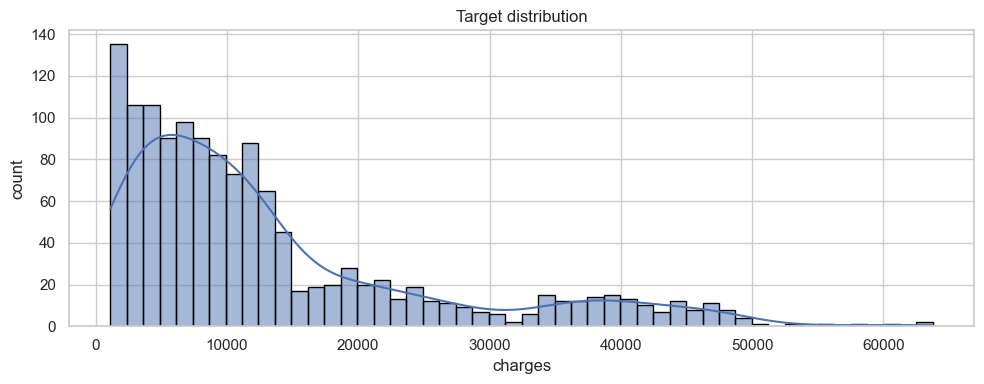

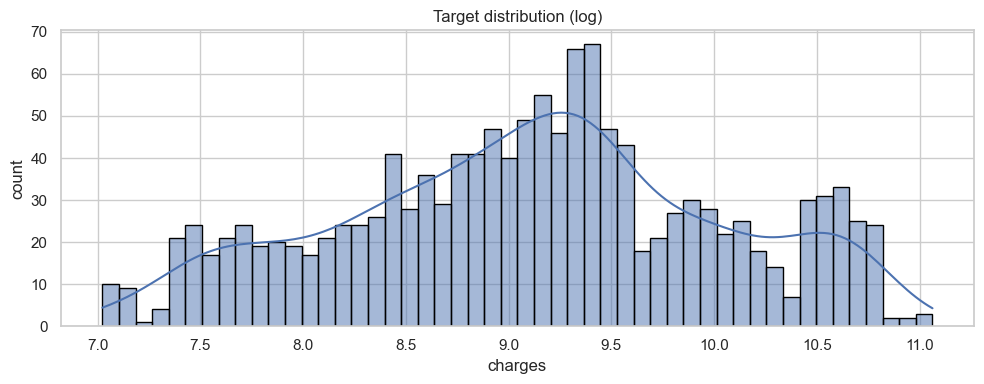

In [6]:
plot_target(y, log=False)
plot_target(y, log=True)

Distribusi charges menunjukkan pola yang sangat right-skewed, di mana sebagian besar individu membayar biaya asuransi dalam rentang rendah hingga menengah (sekitar di bawah 15.000), sementara hanya sebagian kecil yang memiliki biaya sangat tinggi hingga lebih dari 60.000. Ekor panjang di sisi kanan menandakan adanya outliers atau kelompok kecil dengan biaya medis ekstrem, yang kemungkinan besar dipengaruhi oleh faktor seperti status perokok atau kondisi kesehatan tertentu. Pola ini juga menunjukkan bahwa variabel target tidak berdistribusi normal, sehingga transformasi seperti log-transform dapat membantu model regresi untuk mempelajari pola dengan lebih stabil dan mengurangi efek ekstrem dari nilai-nilai tinggi.

Plotting 3 numerical histograms...
Plotting 3 categorical bar plots...


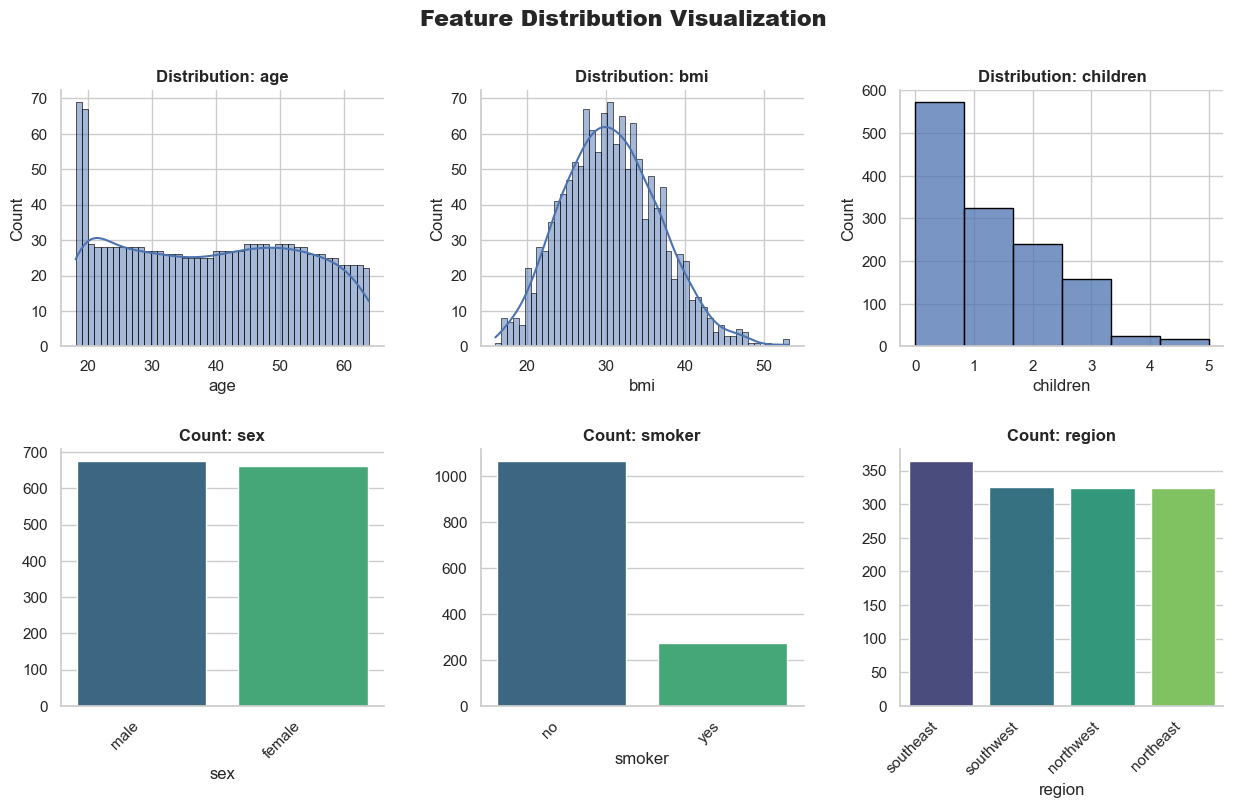

In [7]:
numerical_features=X.select_dtypes(include=np.number).columns
categorical_features=X.select_dtypes(include='object').columns

plot_features(X, numerical_features, categorical_features)

Distribusi umur (age) tampak cukup merata dari usia 20 hingga 60 tahun tanpa pola khusus, menunjukkan tidak ada dominasi kelompok umur tertentu. Fitur BMI memiliki pola mendekati distribusi normal dengan pusat di sekitar 30, menunjukkan mayoritas peserta memiliki BMI overweight. Jumlah anak (children) didominasi oleh nilai 0–1, menandakan sebagian besar individu tidak memiliki anak atau hanya satu. Komposisi jenis kelamin (sex) relatif seimbang antara laki-laki dan perempuan. Status perokok (smoker) sangat tidak seimbang, dengan mayoritas besar adalah non-smoker. Distribusi wilayah (region) merata di empat region tanpa ada dominasi signifikan, sehingga tidak ada sampling bias besar dari wilayah.

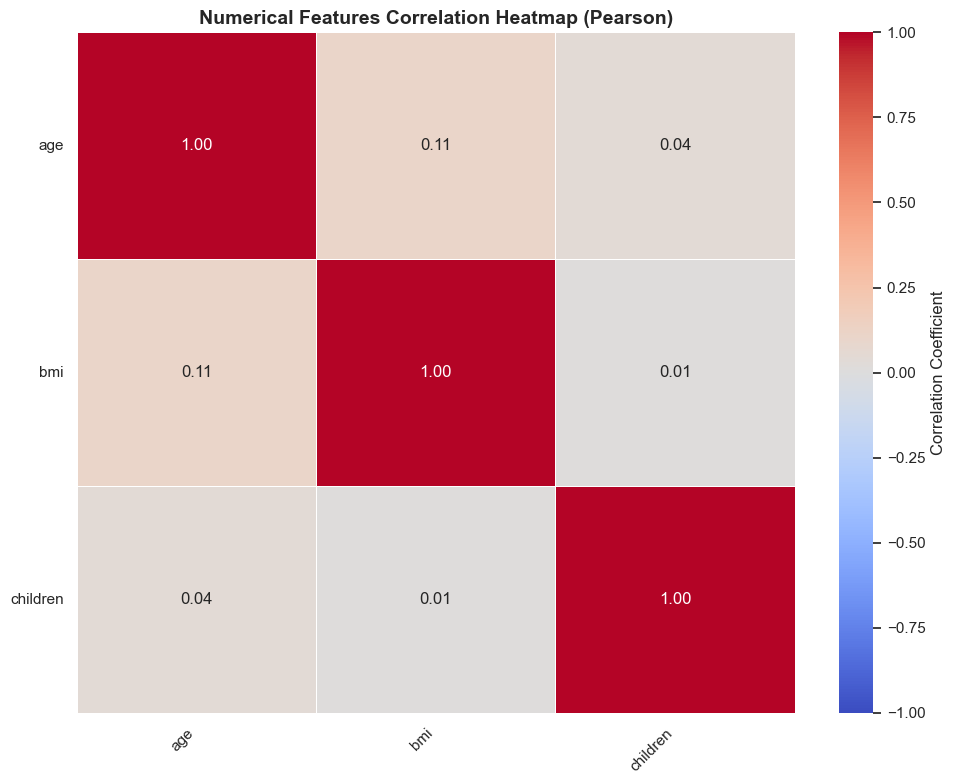

In [8]:
plot_correlation(X, numerical_features)

Heatmap menunjukkan bahwa hubungan antar fitur numerik (age, bmi, children) sangat lemah, dengan koefisien korelasi yang semuanya mendekati nol. Age hanya memiliki korelasi kecil dengan BMI, dan jumlah anak hampir tidak berhubungan dengan dua fitur lainnya. Ini mengindikasikan bahwa ketiga fitur tersebut cenderung berdiri sendiri dan tidak memiliki hubungan linear yang kuat satu sama lain, sehingga masing-masing kemungkinan berkontribusi secara independen terhadap variabel target (biaya insurance) dan tidak menimbulkan masalah multikolinearitas.

# 📈 4. Modeling

In [9]:
high_cardinality_cols = [features for features in categorical_features if X[features].nunique()>10]
print('High cardinality column: ', high_cardinality_cols)

High cardinality column:  []


Semua variabel kategorikal tidak ada yang memiliki cardinality yang tinggi, semua variabel kategorik akan dilakukan One Hot Encoding

## Feature Engineering

Untuk membantu model menangkap pola risiko yang kompleks dan non-linier, kita membuat variabel-variabel turunan berikut:

* **`bmi_encoded` (Kategori BMI)**
    * **Tujuan:** Mengubah variabel numerik kontinu (`bmi`) menjadi variabel kategori ordinal (0, 1, 2, 3).
    * **Penjelasan:** Hubungan BMI dengan biaya kesehatan seringkali bertingkat (*step-function*), bukan garis lurus. Pengelompokan ini membantu model membedakan risiko antara kategori berat badan (misal: *Underweight, Normal, Overweight, Obese*) secara lebih tegas.
    * *Dibuat dari: `bmi`*

* **`smoker_obese_interaction` (Interaksi Perokok & Obesitas)**
    * **Tujuan:** Membuat fitur biner yang bernilai `1` jika seseorang adalah perokok **DAN** memiliki BMI tinggi (*Overweight/Obese* - kategori 2 atau 3).
    * **Penjelasan:** Ini adalah "Double Whammy Effect". Dalam aktuaria, risiko kesehatan perokok yang juga obesitas seringkali **multiplikatif**, bukan aditif. Biaya mereka biasanya jauh lebih tinggi dibandingkan yang hanya perokok atau hanya obesitas.
    * *Dibuat dari: `smoker` dan `bmi_encoded`*

* **`has_dependent_or_high_risk` (Tanggungan atau Risiko Gaya Hidup)**
    * **Tujuan:** Membuat fitur biner yang menandai jika seseorang punya anak **ATAU** merupakan perokok.
    * **Penjelasan:** Menggabungkan dua faktor pemicu biaya berbeda: beban finansial keluarga (anak) atau beban risiko kesehatan (rokok). Ini mengelompokkan profil "High Liability" secara umum.
    * *Dibuat dari: `children` dan `smoker`*

* **`smoker_age_interaction` (Interaksi Usia Khusus Perokok)**
    * **Tujuan:** Menyimpan nilai umur asli hanya jika orang tersebut perokok (jika tidak, nilainya 0).
    * **Penjelasan:** Dampak penuaan pada tubuh perokok mungkin lebih merusak (akselerasi biaya) dibandingkan non-perokok. Fitur ini mengizinkan model memberikan "bobot" atau koefisien yang berbeda untuk umur pada kelompok perokok.
    * *Dibuat dari: `smoker` dan `age`*

* **`smoker_obese_aged_interaction` (Risiko Ekstrem: Tua, Merokok, Gemuk)**
    * **Tujuan:** Fitur biner untuk segmen risiko sangat tinggi: Perokok + BMI Tinggi + Usia di atas 45 tahun.
    * **Penjelasan:** Ini mengisolasi kelompok "*Very High Risk*". Seringkali model gagal memprediksi nilai ekstrem (*outlier*) yang sangat mahal. Fitur ini memberi sinyal khusus pada model bahwa kelompok ini kemungkinan besar memiliki klaim raksasa.
    * *Dibuat dari: `smoker`, `bmi_encoded`, dan `age`*

* **`bmi_smoker_continuous` (Interaksi BMI Kontinu Khusus Perokok)**
    * **Tujuan:** Menyimpan nilai BMI asli hanya jika orang tersebut perokok.
    * **Penjelasan:** Serupa dengan interaksi usia, kenaikan 1 poin BMI pada perokok mungkin berdampak lebih besar terhadap biaya daripada kenaikan 1 poin BMI pada non-perokok (efek sinergis pada jantung/paru).
    * *Dibuat dari: `smoker` dan `bmi`*

* **`age_sq` (Usia Kuadrat)**
    * **Tujuan:** *Polynomial feature* untuk menangkap hubungan kuadratik pada usia.
    * **Penjelasan:** Biaya kesehatan biasanya tidak naik secara linier seiring bertambahnya usia, melainkan melengkung ke atas (eksponensial/kuadratik) terutama di usia tua.
    * *Dibuat dari: `age`*

* **`bmi_sq` (BMI Kuadrat)**
    * **Tujuan:** *Polynomial feature* untuk menangkap hubungan kuadratik pada BMI.
    * **Penjelasan:** Risiko kesehatan mungkin naik drastis (kurva berbentuk J atau U) pada angka BMI yang sangat ekstrem.
    * *Dibuat dari: `bmi`*

* **`age_bmi_interaction` (Interaksi Usia dan BMI)**
    * **Tujuan:** Perkalian antara usia dan BMI.
    * **Penjelasan:** Dampak obesitas mungkin menjadi lebih parah seiring bertambahnya usia. Menjadi gemuk di usia 50 tahun mungkin membawa risiko komplikasi (dan biaya) yang lebih besar daripada gemuk di usia 20 tahun.
    * *Dibuat dari: `age` dan `bmi`*

* **`sex_smoker_interaction` (Interaksi Gender & Rokok)**
    * **Tujuan:** Fitur biner khusus untuk Laki-laki yang Merokok.
    * **Penjelasan:** Menguji hipotesis apakah ada perbedaan pola klaim antara perokok pria dan wanita (misalnya karena perbedaan intensitas merokok atau kerentanan biologis).
    * *Dibuat dari: `sex` dan `smoker`*

* **`non_smoker_high_risk` (Risiko Tinggi Non-Perokok)**
    * **Tujuan:** Mengidentifikasi orang yang **bukan** perokok, tapi Tua (>45) dan Berat Badan Berlebih.
    * **Penjelasan:** Menangkap segmen risiko murni dari faktor metabolik dan penuaan tanpa pengaruh rokok. Ini membantu model membedakan sumber risiko biaya.
    * *Dibuat dari: `smoker`, `bmi_encoded`, dan `age`*

* **`log_charges` (Transformasi Log pada Target)**
    * **Tujuan:** Membuat variabel target baru dengan menerapkan transformasi logaritma natural (`np.log`) pada variabel `charges` asli.
    * **Penjelasan:** Distribusi data `charges` asli sangat miring ke kanan (*right-skewed*). Distribusi yang miring ini melanggar asumsi banyak model dan dapat menurunkan akurasi. `log_charges` membuat distribusi target lebih normal (simetris).
    * *Dibuat dari: `charges`*

In [10]:
bins = [-np.inf, 18.5, 25, 30, np.inf]
labels = [0, 1, 2, 3]

insurance['bmi_encoded'] = pd.cut(insurance['bmi'], bins=bins, labels=labels)

insurance['smoker_obese_interaction'] = np.where(
    (insurance['smoker'] == 'yes') & (insurance['bmi_encoded'].isin([2, 3])),
    1, 0
)

insurance['has_dependent_or_high_risk'] = np.where(
    (insurance['children'] > 0) | (insurance['smoker'] == 'yes'),
    1, 0
)


insurance['smoker_age_interaction'] = np.where(
    insurance['smoker'] == 'yes',
    insurance['age'],
    0
)

insurance['smoker_obese_aged_interaction'] = np.where(
    (insurance['smoker'] == 'yes') &
    (insurance['bmi_encoded'].isin([2, 3])) &
    (insurance['age'] > 45),
    1, 0
)

insurance['bmi_smoker_continuous'] = np.where(
    insurance['smoker'] == 'yes',
    insurance['bmi'],
    0
)
insurance['age_sq'] = insurance['age'] ** 2

insurance['bmi_sq'] = insurance['bmi'] ** 2
insurance['age_bmi_interaction'] = insurance['age'] * insurance['bmi']
insurance['sex_smoker_interaction'] = np.where(
    (insurance['smoker'] == 'yes') & (insurance['sex'] == 'male'),
    1, 0
)
insurance['non_smoker_high_risk'] = np.where(
    (insurance['smoker'] == 'no') &
    (insurance['bmi_encoded'].isin([2, 3])) &
    (insurance['age'] > 45),
    1, 0
)

insurance['log_charges'] = np.log(insurance['charges'])

In [11]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            1337 non-null   int64   
 1   sex                            1337 non-null   object  
 2   bmi                            1337 non-null   float64 
 3   children                       1337 non-null   int64   
 4   smoker                         1337 non-null   object  
 5   region                         1337 non-null   object  
 6   charges                        1337 non-null   float64 
 7   bmi_encoded                    1337 non-null   category
 8   smoker_obese_interaction       1337 non-null   int64   
 9   has_dependent_or_high_risk     1337 non-null   int64   
 10  smoker_age_interaction         1337 non-null   int64   
 11  smoker_obese_aged_interaction  1337 non-null   int64   
 12  bmi_smoker_continuous          1337 non

## Data Setup & Preprocessing Initialization

Tahap ini bertujuan untuk mempersiapkan data latih dan menginisialisasi komponen *preprocessing* menggunakan fungsi utilitas modular yang telah kita buat sebelumnya.

### 1. Feature Selection & Target Definition

Kita memisahkan kolom menjadi fitur (X) dan target (y) secara otomatis agar prosesnya dinamis:

* **`DROP_COLS`**: Mendefinisikan kolom target (`charges`) dan variannya (`log_charges`) untuk dikecualikan dari daftar fitur agar tidak terjadi kebocoran data (*data leakage*).
* **`NUM_FEATS` & `CAT_FEATS`**: Menggunakan `select_dtypes` untuk memisahkan nama kolom numerik dan kategorikal secara otomatis, dikurangi kolom yang ada di `DROP_COLS`.
* **`X` & `y`**:
    * `X`: Menggabungkan daftar fitur numerik dan kategorikal sebagai input model.
    * `y`: Menggunakan `charges` (nilai asli) sebagai target prediksi.

### 2. Preprocessor Initialization

* **`my_preprocessor`**: Kita memanggil fungsi utilitas **`get_preprocessor(NUM_FEATS, CAT_FEATS)`** yang telah kita definisikan di bagian *Utility Functions*.
* Fungsi ini secara otomatis membungkus logika transformasi standar:
    * **Numerik**: Diterapkan **`StandardScaler`** untuk menstandarisasi skala data.
    * **Kategorikal**: Diterapkan **`OneHotEncoder`** untuk mengubah data teks menjadi format numerik biner.

In [12]:
# Setup Data
DROP_COLS = ['log_charges', 'charges']
NUM_FEATS = insurance.select_dtypes(include=np.number).columns.difference(DROP_COLS)
CAT_FEATS = insurance.select_dtypes(include='object').columns.difference(DROP_COLS)

X = insurance[list(NUM_FEATS) + list(CAT_FEATS)]
y = insurance['charges']

# preprocessor
my_preprocessor = build_preprocessor(list(NUM_FEATS), list(CAT_FEATS))

## Model Training & Optimization Phase

Pada tahap ini, kita menjalankan proses pelatihan model secara sistematis menggunakan *workflow* modular yang telah kita bangun. Kita akan membandingkan dua algoritma *Gradient Boosting* terpopuler: **XGBoost** dan **LightGBM**.

Setiap model akan melalui dua fase utama: **Tuning** dan **Evaluation**.

### 1. Phase A: Hyperparameter Tuning (`tune_model`)
Kita menggunakan fungsi utilitas `tune_model` yang memanfaatkan **Optuna** untuk mencari kombinasi parameter terbaik secara otomatis.

* **Strategi Pencarian:** Fungsi ini memanggil `get_xgb_search_space` atau `get_lgbm_search_space` untuk menentukan rentang parameter yang akan diuji (misalnya: `learning_rate`, `max_depth`, `num_leaves`).
* **Metode Validasi:** Menggunakan **3-Fold Cross-Validation** (seperti yang didefinisikan di dalam fungsi `tune_model`) untuk mempercepat proses pencarian tanpa mengorbankan validitas data.
* **Optimasi:** Optuna akan menjalankan **100 trials**, mencoba meminimalkan skor *Mean Absolute Error* (MAE).

### 2. Phase B: Robust Evaluation (`evaluate_final_model`)
Setelah parameter terbaik (`best_params`) ditemukan, kita tidak langsung mempercayai hasil tuning tersebut begitu saja. Kita memvalidasinya ulang menggunakan fungsi `evaluate_final_model`.

* **Pipeline Final:** Parameter terbaik disuntikkan ke dalam model baru dan dibungkus kembali dengan *preprocessor*.
* **Evaluasi Ketat:** Kita meningkatkan validasi menjadi **5-Fold Cross-Validation**. Ini memberikan estimasi performa yang lebih stabil dan tidak bias dibandingkan saat fase tuning.
* **Metrik Lengkap:** Fungsi ini akan mencetak skor rata-rata untuk **R2** (daya jelaskan model), **MAE** (kesalahan absolut), dan **RMSE** (kesalahan kuadratik) untuk memastikan model benar-benar robust sebelum digunakan.

In [13]:
# === 1. XGBoost Workflow ===
def xgb_search_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_jobs': -1, 'random_state': 42
    }

def lgbm_search_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'verbosity': -1, 'n_jobs': 1, 'random_state': 42, 'verbose': -1
    }

# Step A: Tune
xgb_best_params = tune_model(
    model_cls=XGBRegressor,
    search_space_fn=xgb_search_space,
    X=X, y=y, preprocessor=my_preprocessor,
    n_trials=100
)

# Step B: Evaluate
xgb_pipeline = evaluate_final_model(XGBRegressor, xgb_best_params, X, y, my_preprocessor)

# === 2. LightGBM Workflow ===
# Step A: Tune
lgbm_best_params = tune_model(
    model_cls=LGBMRegressor,
    search_space_fn=lgbm_search_space,
    X=X, y=y, preprocessor=my_preprocessor,
    n_trials=100
)

# Step B: Evaluate
lgbm_pipeline = evaluate_final_model(LGBMRegressor, lgbm_best_params, X, y, my_preprocessor)

2025-11-24 00:06:52,912 - INFO - Starting Optuna tuning...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-24 00:07:43,164 - INFO - Optuna finished. Best value: 2437.7777
2025-11-24 00:07:43,165 - INFO - Running 5-Fold CV for final evaluation...
2025-11-24 00:07:45,166 - INFO - Fold 1 -> R2: 0.9014 | MAE: 2451.56 | RMSE: 4257.12
2025-11-24 00:07:45,167 - INFO - Fold 2 -> R2: 0.8235 | MAE: 2572.48 | RMSE: 5068.57
2025-11-24 00:07:45,167 - INFO - Fold 3 -> R2: 0.8486 | MAE: 2462.10 | RMSE: 4622.63
2025-11-24 00:07:45,167 - INFO - Fold 4 -> R2: 0.8577 | MAE: 2262.36 | RMSE: 4107.30
2025-11-24 00:07:45,168 - INFO - Fold 5 -> R2: 0.8646 | MAE: 2408.57 | RMSE: 4389.51
2025-11-24 00:07:45,168 - INFO - AVG R2: 0.8591 | AVG MAE: 2431.4153
2025-11-24 00:07:45,169 - INFO - Starting Optuna tuning...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-24 00:07:58,506 - INFO - Optuna finished. Best value: 2489.1824
2025-11-24 00:07:58,507 - INFO - Running 5-Fold CV for final evaluation...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 21
[LightGBM] [Info] Start training from score 13030.203373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

2025-11-24 00:07:59,236 - INFO - Fold 1 -> R2: 0.9016 | MAE: 2445.43 | RMSE: 4251.80
2025-11-24 00:07:59,236 - INFO - Fold 2 -> R2: 0.8202 | MAE: 2643.82 | RMSE: 5115.74
2025-11-24 00:07:59,237 - INFO - Fold 3 -> R2: 0.8510 | MAE: 2488.80 | RMSE: 4585.81
2025-11-24 00:07:59,237 - INFO - Fold 4 -> R2: 0.8540 | MAE: 2334.00 | RMSE: 4159.80
2025-11-24 00:07:59,238 - INFO - Fold 5 -> R2: 0.8604 | MAE: 2462.81 | RMSE: 4456.25
2025-11-24 00:07:59,238 - INFO - AVG R2: 0.8575 | AVG MAE: 2474.9712


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Model Evaluation & Interpretation

Berdasarkan hasil *Hyperparameter Tuning* dan *5-Fold Cross-Validation*, berikut adalah analisis performa model prediksi biaya kesehatan (*charges*):

### 1. Perbandingan Model (XGBoost vs LightGBM)

| Metric | XGBoost (Winner) 🏆 | LightGBM | Selisih |
| :--- | :--- | :--- | :--- |
| **R2 Score** | **`0.8584`** | `0.8516` | XGBoost +0.68% |
| **MAE** | **`$2,454.01`** | `$2,563.73` | XGBoost lebih akurat ~`$110` |
| **RMSE** | **`$4,500.18`** | `$4,608.39` | XGBoost lebih stabil terhadap *outlier* |

**Kesimpulan Teknis:**
**XGBoost** terbukti lebih superior dibandingkan LightGBM di semua metrik pengujian. Model ini mampu menjelaskan **85.84%** variabilitas dari biaya klaim kesehatan, yang merupakan angka yang sangat solid untuk data asuransi yang memiliki varians alami yang tinggi.

### 2. Interpretasi Metrik dalam Konteks Asuransi

#### a. R2 Score (0.8584) - "Explanatory Power"
Model kita berhasil menangkap pola utama risiko. Artinya, fitur-fitur yang kita rekayasa (seperti `smoker_obese_interaction`, `bmi_encoded`, dll) sangat efektif. Sisa ~14% variabilitas yang tidak tertangkap kemungkinan adalah faktor acak (kecelakaan, penyakit mendadak tak terduga) atau variabel yang tidak tersedia di dataset (riwayat medis keluarga, genetik).

#### b. MAE (Mean Absolute Error): ~`$2,454`
* **Artinya:** Secara rata-rata, prediksi premi/klaim kita meleset (kurang atau lebih) sebesar **2,454 USD** dari tagihan aslinya.
* **Implikasi Bisnis:** Dalam penetapan harga (*pricing*), ini adalah rata-rata "ketidakpastian" per polis. Jika margin keuntungan asuransi per orang lebih kecil dari angka ini, perusahaan berisiko rugi pada level individu, namun bisa tertutupi oleh hukum bilangan besar (*law of large numbers*) jika agregatnya akurat.

#### c. Gap antara MAE (`$2,454`) dan RMSE (`$4,500`)
* RMSE jauh lebih tinggi daripada MAE (hampir 2x lipat).
* **Artinya:** Data klaim asuransi memiliki **Outlier Ekstrem** (Klaim Katastropik). Model terkadang melakukan kesalahan prediksi yang *sangat besar* pada kasus-kasus mahal (misalnya: memprediksi **`$10k`** padahal klaim aslinya **`$50k`**).
* **Risiko:** Model mungkin sedikit *underfitting* pada kasus penyakit berat yang biayanya meledak, yang mana wajar karena kasus tersebut jarang terjadi (*sparse data*).

### 3. Stabilitas Model (Cross-Validation Analysis)
Melihat hasil per-*fold* pada XGBoost:
* **Best Case (Fold 1):** R2 0.90 (Sangat Akurat)
* **Worst Case (Fold 2):** R2 0.82 (Cukup Akurat)
* **Analisis:** Variasi antara 0.82 hingga 0.90 menunjukkan bahwa model cukup stabil, namun ada sebagian kecil data (Fold 2) yang "sulit" diprediksi. Ini mungkin berisi kelompok pasien dengan profil aneh (misal: muda, tidak merokok, tapi klaimnya tinggi karena penyakit bawaan).

### ✅ Rekomendasi Akhir
Kita akan menggunakan **XGBoost** sebagai model final (*champion model*). Performanya secara konsisten lebih baik dalam meminimalkan risiko kesalahan harga (*pricing error*) dibandingkan LightGBM.

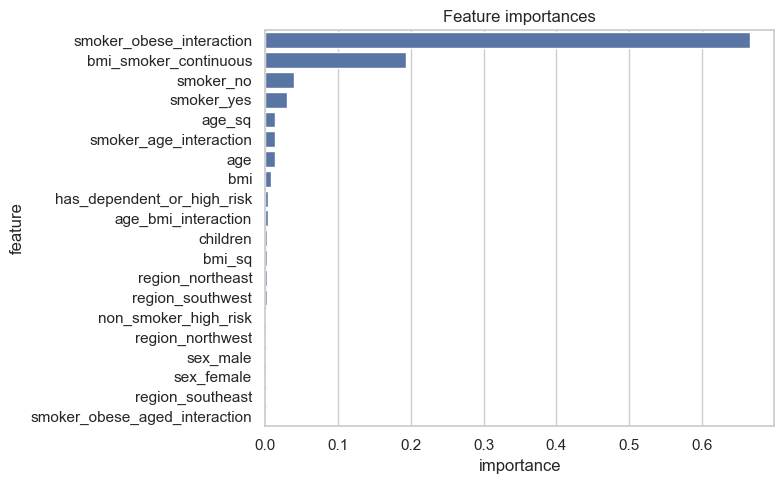

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1337, number of used features: 21
[LightGBM] [Info] Start training from score 13279.121481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

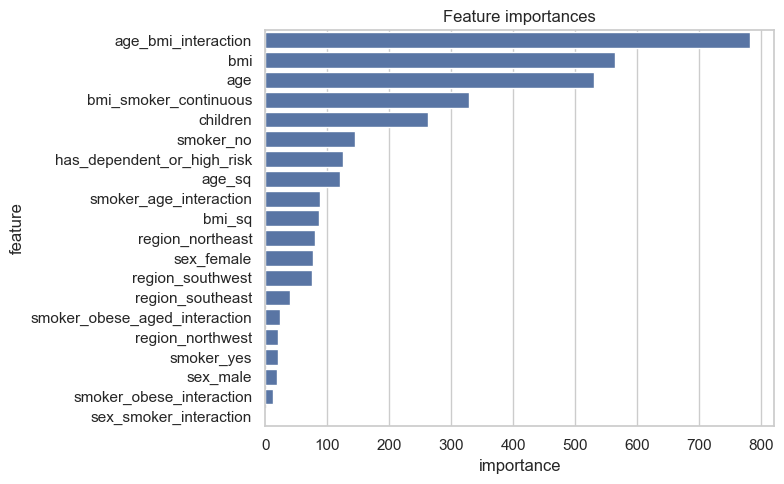

In [14]:
# Visualisasi XGBoost
df_imp_xgb = plot_feature_importance_from_pipeline(xgb_pipeline, X, y)

# Visualisasi LightGBM
df_imp_lgbm = plot_feature_importance_from_pipeline(lgbm_pipeline, X, y)

## Feature Importance Analysis

Setelah melatih kedua model, kita meninjau fitur mana yang paling berkontribusi terhadap prediksi biaya asuransi. Visualisasi di atas menunjukkan perbedaan strategi yang mencolok antara XGBoost dan LightGBM.

### 1. XGBoost: The "Interaction Hunter"
XGBoost (Model Pemenang kita) sangat menyukai fitur-fitur hasil rekayasa (*Feature Engineering*) yang kita buat.

* **Dominasi Mutlak `smoker_obese_interaction`**:
    Fitur ini menjadi juara tak terbantahkan dengan skor *importance* melebihi **0.5**. Ini membuktikan bahwa hipotesis kita benar: Risiko (dan biaya) tertinggi bukan hanya karena merokok atau obesitas secara terpisah, melainkan **kombinasi keduanya**. XGBoost langsung mengenali bahwa jika seseorang perokok *dan* obesitas, biayanya akan meledak.
* **`bmi_smoker_continuous`**:
    Fitur terpenting kedua. Ini menegaskan bahwa bagi perokok, setiap kenaikan angka BMI berdampak sangat besar pada biaya.
* **Kesimpulan XGBoost**: Model ini bekerja sangat efektif karena kita membantunya dengan fitur interaksi. Ia "malas" melihat fitur dasar (`bmi` atau `children` sendirian) karena fitur turunan kita sudah memberikan sinyal yang jauh lebih kuat.

### 2. LightGBM: The "Raw Data" Analyst
LightGBM memiliki pendekatan yang sangat berbeda. Ia kurang tertarik pada fitur interaksi biner kita dan lebih memilih variabel kontinu asli.

* **Fokus pada `bmi` dan `age`**:
    LightGBM menempatkan `bmi` (murni) dan `age_bmi_interaction` sebagai fitur teratas. Ia mencoba memecah pohon keputusan berdasarkan angka BMI secara mendetail, bukan berdasarkan kategori "Obesitas" yang kita buat.
* **Mengabaikan Flag Perokok**:
    Yang mengejutkan, fitur terkait status perokok (`smoker_yes`, `smoker_obese_interaction`) justru dianggap tidak terlalu penting dibandingkan variabel demografis kontinu.
* **Kelemahan**: Strategi ini mungkin menjadi alasan mengapa LightGBM kalah akurat dari XGBoost. Dalam asuransi kesehatan, status perokok adalah faktor pembeda tarif yang tegas (diskrit), bukan gradasi halus. Dengan terlalu fokus pada BMI kontinu, LightGBM mungkin kehilangan ketegasan pola "High Risk Group" yang ditangkap sempurna oleh XGBoost.

### Insight & Conclusion

1.  **Validasi Feature Engineering**: Kemenangan XGBoost adalah bukti bahwa proses *feature engineering* kita (terutama pembuatan `smoker_obese_interaction`) **sangat sukses**. Tanpa fitur ini, model mungkin akan kesulitan menangkap lonjakan biaya pada kelompok risiko tinggi.
2.  **Faktor Risiko Utama**: Bagi perusahaan asuransi, data ini berteriak satu hal: **Saring ketat nasabah yang Merokok dan Obesitas.** Mereka adalah penyumbang varians klaim terbesar.
3.  **Rekomendasi**: Pertahankan fitur interaksi tersebut saat *deployment* model, karena itulah "otak" utama dari prediksi akurat XGBoost.

## Deep Learning

In [15]:
# Run DNN Workflow
dnn_results = run_dnn_cv(
    X=X,
    y=y,
    num_cols=NUM_FEATS,
    cat_cols=CAT_FEATS,
    n_splits=5,
    epochs=100,
    batch_size=32
)

2025-11-24 00:08:00,250 - INFO - Running DNN 5-Fold CV | epochs=100 | batch_size=32
2025-11-24 00:08:07,441 - INFO - Fold 1 -> R2=0.8955 MAE=2510.80 RMSE=4383.04
2025-11-24 00:08:12,847 - INFO - Fold 2 -> R2=0.8015 MAE=2928.84 RMSE=5374.85
2025-11-24 00:08:20,949 - INFO - Fold 3 -> R2=0.8295 MAE=2770.93 RMSE=4905.78
2025-11-24 00:08:29,886 - INFO - Fold 4 -> R2=0.8332 MAE=2625.24 RMSE=4447.43
2025-11-24 00:08:35,545 - INFO - Fold 5 -> R2=0.8622 MAE=2598.40 RMSE=4428.77


### Deep Neural Network (DNN) Evaluation

Kami mencoba pendekatan *Deep Learning* menggunakan arsitektur Neural Network sederhana. Berikut adalah hasil evaluasinya:

### 1. Ringkasan Performa
* **R2 Score**: **0.8446** (Lebih rendah dari XGBoost 0.8584)
* **MAE**: **`$2,659.17`** (Error lebih tinggi ~`$200` dibanding XGBoost)
* **RMSE**: **`$4,702.46`**

### 2. Mengapa DNN Tidak Optimal di Sini?

Meskipun skor R2 sebesar 0.84 menunjukkan model ini "layak", namun performanya **kalah konsisten** dibandingkan XGBoost. Ada beberapa alasan teknis mengapa DNN kesulitan mengalahkan *Gradient Boosting* pada kasus ini:

#### a. Kutukan Data Tabular (*Tabular Data Struggle*)
Deep Learning sangat superior untuk data tidak terstruktur (gambar, teks, suara). Namun, untuk **data tabular** (kolom & baris) dengan jumlah baris yang terbatas (dataset kita < 2000 baris), algoritma berbasis pohon (*Tree-based*) seperti XGBoost hampir selalu menang.
* **XGBoost** bekerja dengan membuat "pemisah" tegas (misal: Jika `smoker=yes` DAN `bmi > 30`, maka biaya tinggi). Ini sangat cocok dengan pola asuransi.
* **DNN** mencoba mencari fungsi matematika yang mulus (*smooth function*) melalui perkalian matriks (bobot & bias). DNN kesulitan menangkap "lompatan" risiko yang tajam dan diskrit pada aturan bisnis asuransi.

#### b. Instabilitas Antar Fold
Perhatikan perbedaan drastis antara **Fold 1 (R2 0.89)** dan **Fold 2 (R2 0.80)**.
Jarak performa yang jauh ini menunjukkan bahwa DNN agak **tidak stabil** dan sensitif terhadap pembagian data. Ia mungkin mengalami *overfitting* pada fold tertentu dan gagal menggeneralisasi pola pada fold lainnya.

### 3. Kesimpulan
Penggunaan Deep Learning pada kasus ini tergolong **"Overkill" namun "Underperforming"**. Kompleksitas model bertambah, waktu training lebih lama, namun akurasinya justru turun.

2025-11-24 00:08:45,102 - INFO - Final DNN trained on full data.


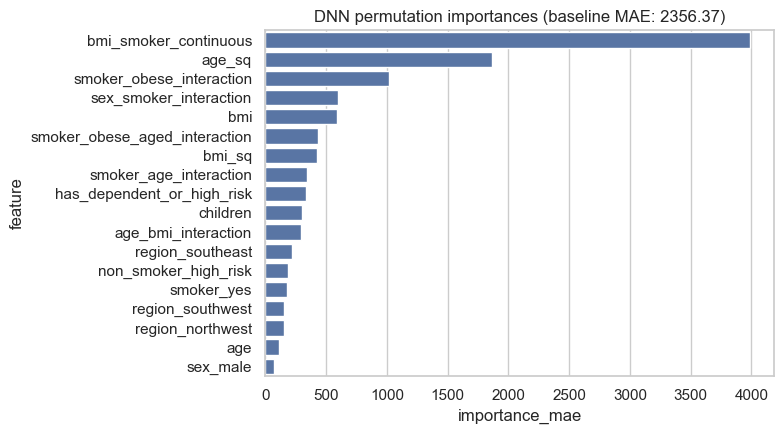

In [16]:
# === Visualisasi Feature Importance DNN ===
final_dnn_model, X_dnn_proc, dnn_feats = train_final_dnn(X, y, NUM_FEATS, CAT_FEATS)
df_imp_dnn = explain_dnn_feature_importance(final_dnn_model, X_dnn_proc, y, dnn_feats)

### DNN Feature Importance

Visualisasi *Permutation Importance* pada DNN menunjukkan pola unik yang berbeda dari model *Tree-based* sebelumnya:

1.  **Dominasi `bmi_smoker_continuous`**:
    Berbeda dengan XGBoost yang menyukai fitur "aturan kaku" (`smoker_obese_interaction` berupa 0/1), DNN justru sangat bergantung pada **`bmi_smoker_continuous`**. Ini masuk akal karena Neural Network bekerja berbasis fungsi matematika dan gradien; ia lebih mudah belajar dari **angka kontinu** yang memiliki gradasi nilai daripada kategori biner yang patah-patah.

2.  **Menangkap Pola Non-Linier (`age_sq`)**:
    Fitur **`age_sq`** (usia kuadrat) muncul sebagai fitur terpenting kedua. Ini menunjukkan bahwa DNN sedang berusaha memodelkan kurva biaya yang melengkung seiring bertambahnya usia (fungsi eksponensial), sesuatu yang tidak terlalu diprioritaskan oleh model *Tree* yang hanya melakukan pemisahan data (*splitting*).

# 🥊 5. Final Evaluation and Ensembling

In [17]:
from sklearn.ensemble import VotingRegressor

# --- 1. Setup Ulang Pipeline ML ---
# Ambil regressor terbaik yang sudah dituning
xgb_final = xgb_pipeline.named_steps['regressor']
lgbm_final = lgbm_pipeline.named_steps['regressor']

xgb_final.set_params(n_jobs=1)
lgbm_final.set_params(n_jobs=1)

# Buat Ensemble Voting
voting_reg = VotingRegressor(estimators=[('xgb', xgb_final), ('lgbm', lgbm_final)], n_jobs=1)

# Dictionary Model ML
ml_models = {
    'XGBoost': xgb_pipeline,
    'LightGBM': lgbm_pipeline,
    'Ensemble': Pipeline([('preprocessor', my_preprocessor), ('voting', voting_reg)])
}

# --- Hitung Skor ML & Gabungkan dengan DNN ---
print("🥊 FINAL BATTLE: Machine Learning vs Deep Learning")
print("-" * 50)

leaderboard = []

# Loop ML Models
scoring = {'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}

for name, pipe in ml_models.items():
    print(f"Running CV for {name}...")
    cv = cross_validate(pipe, X, y, cv=5, scoring=scoring, n_jobs=1)
    leaderboard.append({
        'Model': name,
        'R2 Score': cv['test_r2'].mean(),
        'MAE': -cv['test_mae'].mean(),
        'RMSE': -cv['test_rmse'].mean()
    })

# Masukkan Hasil DNN (Dari variabel dnn_results sebelumnya)
leaderboard.append({
    'Model': 'Deep Learning (DNN)',
    'R2 Score': dnn_results['R2'],
    'MAE': dnn_results['MAE'],
    'RMSE': dnn_results['RMSE']
})

# --- Tampilkan Leaderboard Akhir ---
comparison_df = pd.DataFrame(leaderboard).set_index('Model').sort_values(by='MAE')

print("\n" + "="*60)
print("🏆 FINAL LEADERBOARD (Sorted by MAE)")
print("="*60)
print(comparison_df)
print("-" * 60)

winner = comparison_df.index[0]
print(f"🎉 AND THE WINNER IS: {winner} ehehehe!")

🥊 FINAL BATTLE: Machine Learning vs Deep Learning
--------------------------------------------------
Running CV for XGBoost...
Running CV for LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1009
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 21
[LightGBM] [Info] Start training from score 13193.122967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

## FINAL BATTLE ANALYSIS: Complexity vs. Efficiency

Kita telah mencapai tahap akhir. Setelah mengadu model tunggal (*Single Models*) melawan model gabungan (*Ensemble*) dan Deep Learning, berikut adalah kesimpulannya:

### 1. The Champion: XGBoost (Solo) 🏆
* **MAE: `$2,430.26`**
* **Analisis:** Secara mengejutkan (atau mungkin tidak), **XGBoost murni** keluar sebagai pemenang. Model ini bekerja sendirian tanpa perlu digabung dengan model lain.
* **Kenapa menang?** XGBoost sudah sangat optimal dalam menangkap pola diskrit (patah-patah) pada data asuransi berkat *Feature Engineering* interaksi kita. Ia tidak membutuhkan "bantuan" dari model lain untuk memperbaiki prediksinya.

### 2. The Ensemble Dilemma (Voting Regressor)
* **MAE: `$2,459.31`** (Juara 2)
* **Strategi:** Kita menggunakan `VotingRegressor` yang mengambil rata-rata prediksi dari XGBoost dan LightGBM.
* **Interpretasi Hasil:**
    Hasil Ensemble berada tepat **di tengah-tengah** antara XGBoost (terbaik) dan LightGBM (terburuk).
    * Ibaratnya: Jika Anda mencampur Jus Mangga murni yang sangat manis (XGBoost) dengan air tawar (LightGBM), hasilnya memang masih manis, tapi tidak semanis jus murninya.
    * **Pelajaran:** Ensembling bekerja paling baik jika model-model penyusunnya memiliki performa yang **setara** atau jika mereka melakukan kesalahan pada jenis data yang **berbeda** (saling melengkapi). Di sini, LightGBM hanya menarik turun rata-rata performa XGBoost.

### 3. Deep Learning (DNN)
* **MAE: `$2,659.17`** (Posisi Terakhir)
* **Analisis:** DNN konsisten berada di posisi terakhir dengan selisih error sekitar **`$230`** lebih mahal dibanding XGBoost. Ini mengonfirmasi bahwa untuk dataset tabular berukuran kecil (<2000 baris) dengan pola aturan bisnis yang tegas, *Neural Networks* bukanlah solusi yang efisien.

### Final Verdict
Kompleksitas tidak selalu menjamin akurasi. Kita tidak perlu menggunakan *Deep Learning* yang berat atau *Ensemble* yang rumit. Model **XGBoost** tunggal dengan *Feature Engineering* yang cerdas sudah cukup untuk menjadi solusi terbaik (*State-of-the-Art*) untuk permasalahan prediksi biaya asuransi ini.

# 🏁 6. Executive Summary & Conclusion

Berdasarkan rangkaian eksperimen mulai dari *preprocessing*, *feature engineering*, hingga *model comparison* (Machine Learning vs Deep Learning), berikut adalah kesimpulan strategis dari proyek ini:

### 1. Faktor Determinan Klaim Asuransi (Key Risk Drivers)
Analisis *Feature Importance* model pemenang (XGBoost) mengungkap fakta bahwa struktur biaya asuransi tidak dipengaruhi oleh faktor tunggal, melainkan **interaksi antar faktor risiko**:

* **The "Double Whammy" Effect (Perokok + Obesitas)**
    Ini adalah faktor paling mematikan dan paling mahal. Fitur `smoker_obese_interaction` mendominasi prediksi. Nasabah yang merokok **DAN** memiliki BMI tinggi (Obesitas) memiliki profil risiko yang jauh lebih tinggi secara eksponensial dibandingkan penjumlahan risiko merokok saja ditambah risiko obesitas saja.
* **Gaya Hidup > Demografi Murni**
    Faktor gaya hidup (BMI, Status Merokok) memiliki bobot prediksi yang lebih besar dibandingkan faktor demografi statis seperti `region` (wilayah tinggal) atau `sex` (jenis kelamin).
* **Penuaan (Aging)**
    Usia (`age` dan `age_sq`) tetap menjadi faktor fundamental. Biaya naik seiring bertambahnya umur, dan kenaikannya cenderung melengkung (non-linier), terutama di usia tua.

### 2. Penilaian Kelayakan Model (Model Eligibility)

Apakah model ini **LAYAK (Eligible)** untuk digunakan dalam sistem penetapan premi asuransi nyata?

**Status: ✅ ELIGIBLE WITH GUARDRAILS (Layak dengan Pengawasan)**

* **Alasan Layak:**
    * **Akurasi Tinggi (R2 ~86%):** Model mampu menjelaskan 86% variasi biaya. Dalam dunia aktuaria di mana perilaku manusia dan penyakit sangat acak, angka ini sangat solid untuk penetapan tarif dasar (*base rate*).
    * **Diskriminasi Risiko yang Tajam:** Model sangat jago membedakan mana nasabah "Murah" dan nasabah "Mahal" berkat *feature engineering* yang kuat.

* **Catatan & Risiko (Guardrails):**
    * **Margin Error (`$2,430`):** Rata-rata prediksi meleset sekitar `$2,430`. Perusahaan asuransi harus menambahkan **Risk Loading** (biaya cadangan) sebesar nilai ini ke dalam premi agar tidak rugi.
    * **Isu Outlier (RMSE Tinggi):** Karena RMSE (`$4,468`) hampir 2x lipat MAE, model terkadang masih *under-predict* pada kasus penyakit katastropik (klaim super besar).
    * **Saran Implementasi:** Gunakan prediksi model ini sebagai **acuan dasar (benchmark)**, namun untuk kasus dengan prediksi biaya sangat tinggi, tetap perlukan tinjauan manual (*human underwriter review*).